<p> dataset: https://finance.yahoo.com/quote/GE/history/ </p>
<p>Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC</p>

In [62]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,scale
import seaborn as sns
#from datetime import datetime

In [24]:
df = pd.read_csv('/content/GE.csv')
print(df.head()) #7 columns, including the Date.

         Date       Open       High        Low      Close  Adj Close    Volume
0  2021-02-02  87.040001  90.800003  86.720001  89.919998  89.637161  10558238
1  2021-02-03  89.919998  90.400002  88.559998  89.599998  89.318169   6776850
2  2021-02-04  89.839996  92.000000  89.519997  91.599998  91.311882   8345975
3  2021-02-05  92.080002  92.400002  90.559998  91.199997  90.913132   6477300
4  2021-02-08  91.760002  93.199997  91.279999  92.879997  92.587845   5306813


In [25]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

238   2022-01-11
239   2022-01-12
240   2022-01-13
241   2022-01-14
242   2022-01-18
243   2022-01-19
244   2022-01-20
245   2022-01-21
246   2022-01-24
247   2022-01-25
248   2022-01-26
249   2022-01-27
250   2022-01-28
251   2022-01-31
252   2022-02-01
Name: Date, dtype: datetime64[ns]


In [26]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [27]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [28]:
df_for_training

,Open,High,Low,Close,Adj Close
0,87.040001,90.800003,86.720001,89.919998,89.637161
1,89.919998,90.400002,88.559998,89.599998,89.318169
2,89.839996,92.000000,89.519997,91.599998,91.311882
3,92.080002,92.400002,90.559998,91.199997,90.913132
4,91.760002,93.199997,91.279999,92.879997,92.587845
...,...,...,...,...,...
248,91.510002,91.910004,88.050003,89.320000,89.320000
249,90.000000,91.769997,88.070000,89.900002,89.900002
250,89.300003,92.160004,88.849998,92.099998,92.099998
251,91.610001,94.559998,91.029999,94.480003,94.480003


In [85]:
df_for_training.corr()


,Open,High,Low,Close,Adj Close
Open,1.000000,0.978817,0.976398,0.950210,0.950136
High,0.978817,1.000000,0.974156,0.977664,0.977384
Low,0.976398,0.974156,1.000000,0.977464,0.977855
Close,0.950210,0.977664,0.977464,1.000000,0.999861
Adj Close,0.950136,0.977384,0.977855,0.999861,1.000000


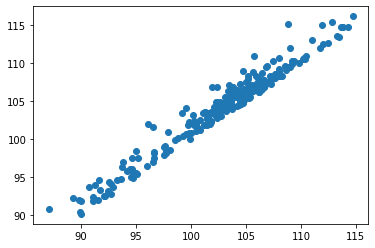

In [84]:
plt.scatter (df['Open'],df['High'])

In [30]:
 #df_for_plot=df_for_training.tail(5000)
 #df_for_plot.plot.line()

In [99]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [100]:
df_for_training_scaled

array([[-2.87705464, -2.46568867, -2.75870531, -2.44955829, -2.48885037],
       [-2.35002478, -2.53989543, -2.41221532, -2.51063278, -2.5501677 ],
       [-2.36466488, -2.24306952, -2.23143783, -2.1289172 , -2.16693188],
       ...,
       [-2.4634818 , -2.21338615, -2.3576054 , -2.0334883 , -2.01543852],
       [-2.04075986, -1.76814785, -1.94708923, -1.57924581, -1.55794882],
       [-1.42040134, -1.05205446, -1.24657553, -0.91697042, -0.89093907]])

In [101]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [102]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [103]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [104]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (239, 14, 5).
trainY shape == (239, 1).


#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that.

# define the Autoencoder model

In [110]:
trainX.shape[1]

14

In [111]:
trainX.shape[2]

5

In [106]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [128]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 0s 18ms/step - loss: 0.0725 - val_loss: 0.1898
Epoch 2/5
14/14 [==============================] - 0s 16ms/step - loss: 0.0685 - val_loss: 0.1651
Epoch 3/5
14/14 [==============================] - 0s 16ms/step - loss: 0.0794 - val_loss: 0.1346
Epoch 4/5
14/14 [==============================] - 0s 15ms/step - loss: 0.0624 - val_loss: 0.1483
Epoch 5/5
14/14 [==============================] - 0s 16ms/step - loss: 0.0721 - val_loss: 0.1140


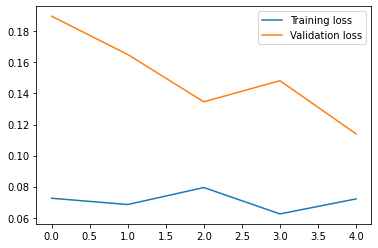

In [129]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [136]:
n_feature=90
predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [137]:
forecast = model.predict (trainX[-n_feature:])

In [140]:
forecast_copices = np.repeat(forecast,df_for_training.shape[1],axis=1)
y_pred_feature = scaler.inverse_transform(forecast_copices)[:,0]

In [141]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [143]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_feature})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [144]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


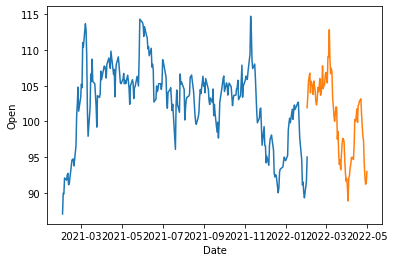

In [145]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])